Reference : https://medium.com/zero-equals-false/n-step-td-method-157d3875b9cb

We will be using Random Walk Environment for N-Step TD Algorithm implementation. The environment is not present in OpenAI Gym Environment. But I found it in following repo : https://github.com/mimoralea/gym-walk. Uncomment the following cell and run it to install the package.

!pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk

# N-Step Temporal-Difference Methods

### Part 0: Explore RandomWalk Env

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import gym_walk

import pandas as pd
import numpy as np
from collections import defaultdict, deque


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import math

Use the code cell below to create an instance of the [RandomWalk](-) environment.

In [2]:
env = gym.make('WalkFive-v0')

In [3]:
env.observation_space.n

7

In [4]:
env.P

{0: {0: [(1.0, 0, 0.0, True), (0.0, 0, 0.0, True), (0.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True), (0.0, 0, 0.0, True), (0.0, 0, 0.0, True)]},
 1: {0: [(1.0, 0, 0.0, True), (0.0, 1, 0.0, False), (0.0, 2, 0.0, False)],
  1: [(1.0, 2, 0.0, False), (0.0, 1, 0.0, False), (0.0, 0, 0.0, True)]},
 2: {0: [(1.0, 1, 0.0, False), (0.0, 2, 0.0, False), (0.0, 3, 0.0, False)],
  1: [(1.0, 3, 0.0, False), (0.0, 2, 0.0, False), (0.0, 1, 0.0, False)]},
 3: {0: [(1.0, 2, 0.0, False), (0.0, 3, 0.0, False), (0.0, 4, 0.0, False)],
  1: [(1.0, 4, 0.0, False), (0.0, 3, 0.0, False), (0.0, 2, 0.0, False)]},
 4: {0: [(1.0, 3, 0.0, False), (0.0, 4, 0.0, False), (0.0, 5, 0.0, False)],
  1: [(1.0, 5, 0.0, False), (0.0, 4, 0.0, False), (0.0, 3, 0.0, False)]},
 5: {0: [(1.0, 4, 0.0, False), (0.0, 5, 0.0, False), (0.0, 6, 1.0, True)],
  1: [(1.0, 6, 1.0, True), (0.0, 5, 0.0, False), (0.0, 4, 0.0, False)]},
 6: {0: [(1.0, 6, 0.0, True), (0.0, 6, 0.0, True), (0.0, 6, 0.0, True)],
  1: [(1.0, 6, 0.0, True), (0.0, 6, 0

In [28]:
state, done = env.reset(), False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    env.render()
    print(f'Reward : {reward}')


[ABCDE]
Reward : 0.0

[ABCDE]
Reward : 0.0

[ABCDE]
Reward : 0.0

[ABCDE]
Reward : 0.0

[ABCDE]
Reward : 0.0

[ABCDE]
Reward : 0.0

[ABCDE]
Reward : 0.0

[ABCDE]
Reward : 0.0

[ABCDE]
Reward : 0.0


### Part 1: TD Control: Sarsa N Step

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [6]:
def get_epsilon_greedy_action(Q, state, eps):
    nA = len(Q[state])
    if np.random.random() > eps:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(nA)
    return action        

In [7]:
def learn_Q_sarsa(Q, state, action, next_state, next_action, reward, done, gamma, alpha):
    predict = Q[state][action]
    target = reward + gamma *(0 if done else Q[next_state][next_action] )
    new = predict + alpha * (target - predict)
    return new

In [8]:
def plot_metrics(scores, steps):
    # sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    data = pd.DataFrame({'scores':scores, 'steps':steps})
    data = data.rolling(100).mean()
    data.index = pd.Series(range(len(scores)), name='episodes')
    
    sns.lineplot(data=data['scores'], color='green', ax=ax[0])
    sns.lineplot(data=data['steps'], color='orange', ax=ax[1])
    
    # sns.set_theme(style=None)

In [9]:
def plot_values(V):
        # reshape the state-value function
        V = np.reshape(V, (1, 7))
        # plot the state-value function
        fig = plt.figure(figsize=(15,5))
        ax = fig.add_subplot(111)
        im = ax.imshow(V, cmap='cool')
        for (j,i),label in np.ndenumerate(V):
            ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
        plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
        plt.title('State-Value Function')
        plt.show()

In [67]:
def sarsa_n(env, num_episodes, n, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    Q[6] = np.ones(nA)
    
    
    # initialize performance monitor
    ep_scores = []
    ep_steps = []
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        # monitor performance
        score = 0.
        step = 0
        
        ## TODO: complete the function
        
        ### set epsilon ( Random policy )
        eps_i = 1 # min(0.1, 1. /i_episode )
        
        ### Observe S0
        state = env.reset()
        
        ### Select A0
        action = get_epsilon_greedy_action(Q, state, eps_i)
        
        ### Set T
        T = np.inf
        
        ### Track n step state action reward
        states = [state]
        actions = [action]
        rewards = [0]
        
        ### Loop
        for t in itertools.count():
            if t < T:
                next_state, reward, done, info = env.step(action)
                    
                states.append(next_state)
                rewards.append(reward)
                
                if done:
                    T = t + 1
                else:
                    next_action = get_epsilon_greedy_action(Q, next_state, eps_i)
                    actions.append(next_action)
                    
            ### Update time 
            tau = t - n + 1
            if tau >= 0:
                start_i = tau + 1
                end_i = min(tau + n + 1, T+1)
                G = sum(math.pow(gamma, i - tau - 1)*rewards[i] for i in range(start_i, end_i))
                
                if tau + n < T:
                    state_tau_n = states[tau+n]
                    action_tau_n = actions[tau+n]
                    G += math.pow(gamma, n) * Q[state_tau_n][action_tau_n]
                    
                    
                #### Update Q
                state_tau = states[tau]
                action_tau = actions[tau]
                
                Q[state_tau][action_tau] = Q[state_tau][action_tau] + alpha * (G - Q[state_tau][action_tau]) 
            
            ### Break Loop
            if tau == T - 1:
                break
                
            ### t = t + 1
            state = next_state
            action = next_action
            
            ### update performance metrics
            score += reward
            step += 1
        
        
         
        # track performance metrics
        ep_scores.append(score)
        ep_steps.append(step)
        
    # show performance metrics
    plot_metrics(ep_scores, ep_steps)
                                 
    return Q


Episode 50000/50000
Estimated Optimal Policy (LEFT = 0, RIGHT = 1, N/A = -1):
[-1  1  1  1  1  1  0]


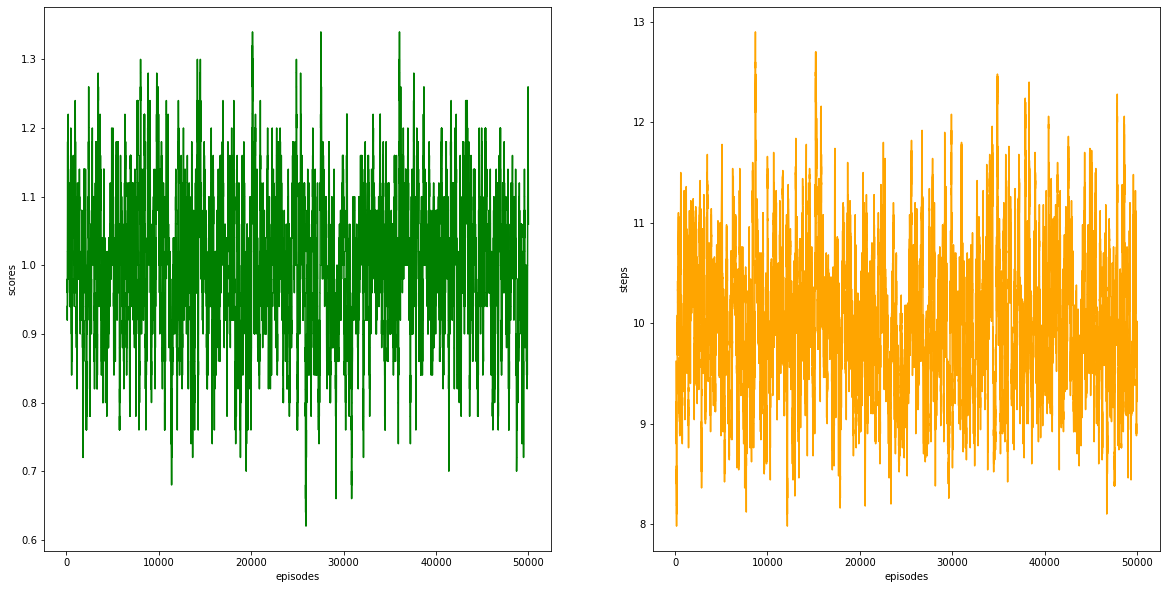

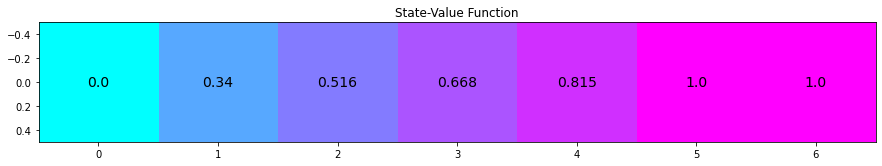

In [68]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa_n = sarsa_n(env, 50000, 3, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa_n[key]) if key in Q_sarsa_n else -1 for key in np.arange(7)])
print("\nEstimated Optimal Policy (LEFT = 0, RIGHT = 1, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa_n[key]) if key in Q_sarsa_n else 0 for key in np.arange(7)])
plot_values(V_sarsa)